# Simulando el Bias-Variance Tradeoff

En este notebook trataremos de explicar y simular el bias-variance tradeoff, el cual afecta **solo a modelos supervisados**.

Los slides se encuentran [aquí](https://www.slideshare.net/xuxoramos/historias-de-ciencia-de-datos-desde-la-trinchera).

Este notebook se basa en el trabajo de [Giorgios Papachristoudis](https://www.linkedin.com/in/geopapa/).

La pieza central para explicar este balance está en esta gráfica:

![](https://miro.medium.com/max/700/1*oO0KYF7Z84nePqfsJ9E0WQ.png)


En un modelo de machine learning, el error tiene 3 componentes: 

1. El error aportado por la varianza inherente al fenómeno que estamos modelando.
2. El sesgo, proveniente de _error no modelado_, con origen en datos no incluídos en el modelo.
3. El error irreducible, el cual es caro e inconveniente de mitigar o tratar.

El **bias-variance tradeoff, coloquialmente, lo podemos frasear como:

> Entre mayor número de predictores o features, mayor varianza, pero menor sesgo, y entre menos predictores, mayor sesgo, y menor varianza. Un buen modelo buscará balancear ambos componentes de error.

**PERO...**

> Los investigadores están descubriendo que en algunas arquitecturas avanzadas de redes neuronales _emergen_ propiedades que los hace resilientes a cumplir forzosamente este tradeoff.

Vamos a tener que describir el error total matemáticamente, para poder pasarlo a código. El error total, con sus 3 componentes está dado por:

![](https://i.imgur.com/9sdp2Wu.png)

Esta ecuación está derivada de la ecuación del _Mean Squared Error_, que es una de las métricas estándar para modelos de regresión:

![](https://miro.medium.com/max/206/1*19oSApfSwSfC-N9xney9kA.png)

Podemos hacer lo mismo para modelos de clasificación, pero para efectos de demostrar el concepto, lo haremos con regresión.

## La función _real_

Para poder simular como logramos este trade-off, debemos primero simular unos datos.

En lugar de hacerlo enteramente _random_, vamos a suponer una función alrededor de la cual podamos luego agregar puntos con _jitter_ que si tenga un componente aleatorio.

Vamos a usar la siguiente función:

![](https://miro.medium.com/max/338/1*q3OGXXALZ0mkAD3Jon9PMw.png)

## El algoritmo de nuestra simulación (en español cristiano apostólico romano)

Basádonos en esta función, nuestra simulación va a seguir este algoritmo:

1. Simular 1000 puntos con _jitter_ originados desde nuestra _función real_.
2. Simular 1 punto para nuestro _test set_, que será nuestra **nueva observación**.
3. Formar un _train set_ con una muestra de 20 puntos. 
4. Entrenar regresiones polinomiales de grados 1, 2, 3 y 5 con este _train set_.
5. Predecir las _y_ con cada regresión polinomial para nuestra **nueva observación** en el _test set_.
6. Repetir 6 experimentos con pasos 2 a 5 para plotear los 20 puntos del _train set_, las regresiones polinomiales, y el punto con la predicción del _test set_.
8. Repetir 10,000 experimentos y plotear el histograma del error por cada experimento y comparar su media del error contra la media del error "real" de los 20 puntos de la muestra.
9. Plotear la cantidad del error VS el grado de las regresiones para la varianza, el sesgo, el error "real" del _test set_, el error del _train set_, y el error irreducible
10. QED :rofl:

## Paso 1 y 2: simular 1000 puntos desde la "función real" y una **nueva observación**

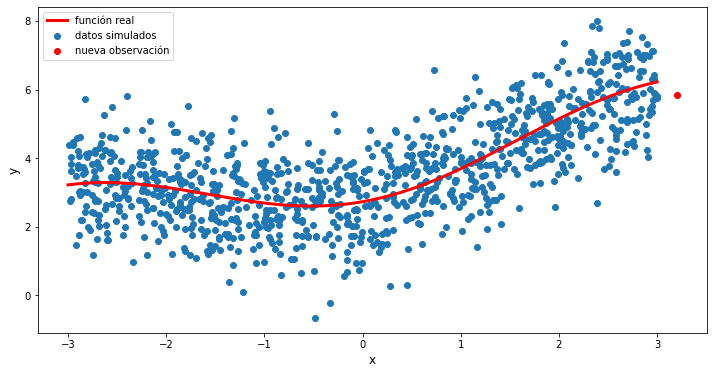

In [9]:
# Librerías
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# DECLARACIÓN DE FUNCIONES
# Función f(x) que va a ser nuestra "función real"
def f(x):
    return .5 * x + np.sqrt(np.max(x, 0)) - np.cos(x) + 2

# VALORES INICIALES
# Num de puntos simulados desde nuestra función f(x)
N = 1000
# Error irreducible
sigma_epsilon = 1
# Máximo en eje X. Vamos a ir desde -3 a 3
x_max = 3
# Valor de x de nuestra "nueva observación", osea, nuestro _test set_ de 1
x_test = 3.2
# Creamos los 1000 puntos de X, todos de -3 a 3
x = x_max * (2 * np.random.rand(N) - 1)
# Creamos las 1000 instancias del error irreducible 
epsilon = sigma_epsilon * np.random.randn(N)
# Creamos las 1000 instancias de y, osea, de f(x), osea, de nuestra función real
y = f(x) + epsilon
# Valor de y para nuestro ÚNICO valor de prueba de x. x_test y y_test constituyen nuestro _test set_
y_test = f(x_test) + sigma_epsilon * np.random.randn()

# PLOTS
# Inicialización de plot
plt.figure(figsize=(12, 6))
# Declaración de rango de eje x, de -3 a 3
x_range = np.linspace(-x_max, x_max, 1000)
# Ploteo de valores x y y simulados desde nuestra f(x) real.
plt.scatter(x, y)
# Ploteo de f(x), nuestra función real.
# OJO! Se supone que NO CONOCEMOS esta función real,
# y es por ello que estamos desarrollando un modelito de ML,
# para poder "aproximar" esta función con los datos que tenemos,
# salidos de la simulación.
plt.plot(x_range, f(x_range), 'r', linewidth=3.0)
# Ploteamos nuestros valores (x,y) de _test_, es decir, nuestra nueva observación
plt.scatter(x_test, y_test, c='r')
# Etiquetas del plot en x y y
plt.xlabel('x', size=12)
plt.ylabel('y', size=12)
# Ticks del eje x para dejar claro que vamos de -3 a 3
plt.xticks(np.arange(-x_max, x_max + 1))
# Leyenda: puntos azules son nuestra simulación,
# línea roja es la función real (que no conocemos),
# y el punto rojo es nuestra nueva observación.
plt.legend(["función real", "datos simulados" , "nueva observación"])

Para efectos de esta simulación, los puntos azules son los pares `(x,y)` que representan el **universo** de nuestra población. Debajo de este fenómeno tenemos la función real `f(x)`, que :eyes:**NO CONOCEMOS**:eyes:, y por lo cual estamos tratando de desarrollar una regresión, para ajustarla a este conjunto de observaciones.

El punto rojo allá solito a la derecha indica **un nuevo** `(x,y)`, una nueva observación, que representa nuestro _test set_.

## Paso 3 al 6: "entrenar" regresiones polinomiales (ord 1, 2, 3 y 5), predecir _f^(x)_ con _test set_, y correr 6 experimentos

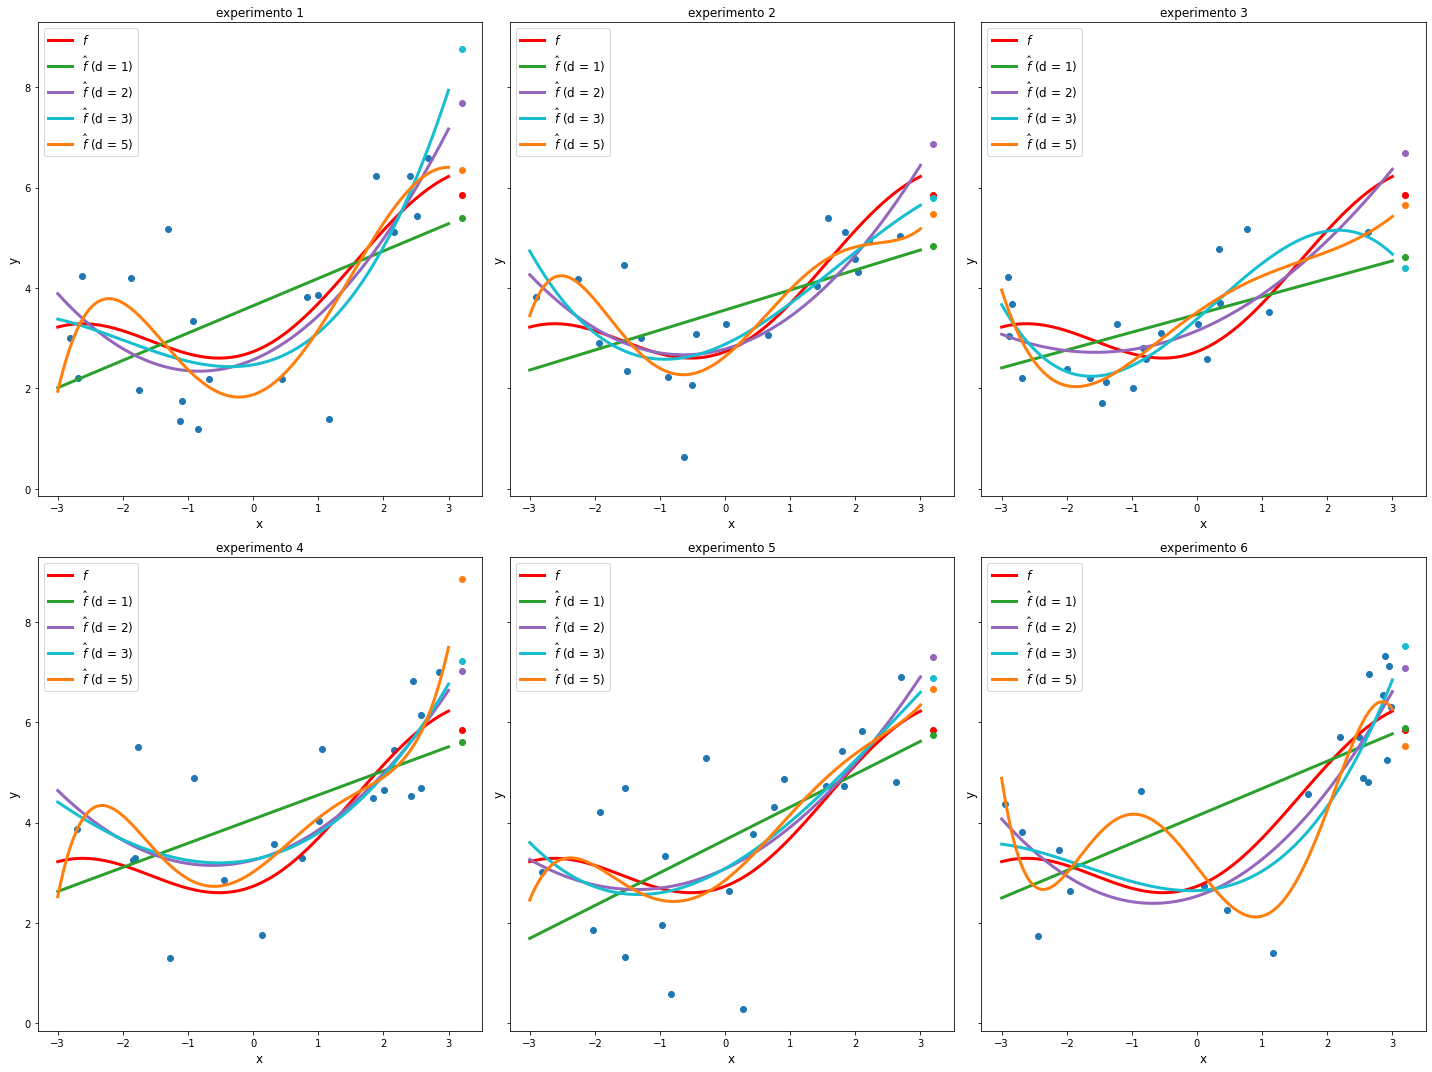

In [24]:
# FUNCIONES
# Definición de la función f^(x), que representa nuestras regresiones polinomiales.
# De nuestros argumentos, x son los valores de entrada, y w son los grados de los
# polinomios que vamos a crear.
# Para eso vamos a usar la función _power_ de numpy, pero esta función solo acepta arreglos
# o matrices del mismo tamaño, por lo que debemos usar _expand_dims_ para que tanto x como
# las potencias tengan la misma forma y dimensiones.
def f_hat(x, w):
    d = len(w) - 1
    return np.sum(w * np.power(x, np.expand_dims(np.arange(d, -1, -1), 1)).T, 1)

# INICIALIZACIÓN DE VARIABLES
# Cantidad de observaciones que vamos a extraer de nuestro universo de 1000 simulaciones
n = int(.02 * N)
# Colores para las gráficas de línea representando cada regresión polinomial:
# - reg lineal: verde
# - reg cuadrática: morado
# - reg cúbica: azul claro
# - reg orden 5: naranja
# 
# Consideremos que también plotearemos f(x), la función original, y que estará en el
# color default: rojo
colors = np.array(['tab:green', 'tab:purple', 'tab:cyan', 'tab:orange'])
# Arreglo de órdenes de polinomios que vamos a ajustar: 1 (lineal), 2 (cuadrática),
# 3 (cúbica), 5 (orden 5)
d_arr = [1, 2, 3, 5]
# Contador de experimentos, solo es una variable auxiliar para ponerle título a
# las gráficas
cnt = 1

# PLOTS
# Configuración del objeto plt para mostrar varios plots en el mismo display,
# similar al facet_grid de ggplot2 en R.
# En este caso vamos a inicializar un grid de 2 x 3.
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20, 15))
# 2 renglones en el _facet_grid_
for i in range(2):
    # 3 plots por renglón
    for j in range(3):
        # Creamos 20 índices aleatorios con los cuales vamos a seleccionar nuestros pares (x,y)
        # de nuestro _train set_
        idx = np.random.permutation(N)[:n]
        # Seleccionamos, con ayuda de los índices anteriores, nuestros pares (x,y) de nuestro
        # _train set_.
        x_train, y_train = x[idx], y[idx]
        # Inicializamos un arreglo de coeficientes para nuestros polinomios
        # que representarán nuestras regresiones
        w = []
        # Iteramos cada uno de los números dentro de nuestro arreglo de órdenes de polinomios
        # que vamos a ajustar
        for d in d_arr:
            # Polyfit en numpy es el método para ajuste de regresiones polinomiales, dado un
            # vector x de variables dependientes y uno y de variables independientes, en nuestro
            # caso, x_train y y_train con la muestra de 20 observaciones que tomamos de nuestro
            # universo.
            # Vamos a ajustar polinomios de orden 1, 2, 3 y 5 a nuestra muestra, y agregarlos
            # a nuestro arreglo de coeficientes.
            w.append(np.polyfit(x_train, y_train, d))
        # Inicializamos la gráfica dentro de la celda (i,j) de nuestro grid con los 20 puntos
        # de la muestra que sacamos de nuestro universo.    
        axs[i, j].scatter(x_train, y_train)
        # Luego agregamos la línea que regresenta la función real f(x)
        axs[i, j].plot(x_range, f(x_range), 'r', linewidth=3.0)
        # Luego iteramos por el arreglo de coeficientes obtenidos...
        for k in range(len(w)):
            # ...y ploteamos las curvas que representan los polinomios de grados 1, 2, 3 y 5,
            # con los colores de nuestro arreglo _colors_ al inicio del bloque.
            # Recordemos que estas son NUESTRAS REGRESIONES
            axs[i, j].plot(x_range, f_hat(x_range, w[k]), colors[k], linewidth=3.0)
        # Ploteamos el puntito que representa nuestra nueva observación    
        axs[i, j].scatter(x_test, y_test, c='r')
        # Luego iteramos por el arreglo de coeficientes obtenidos...
        for k in range(len(w)):
            # ...para plotear la PREDICCIÓN que cada polinomio da para los valores de
            # nuestro _test set_, osea, para nuestra NUEVA OBSERVACIÓN
            axs[i, j].scatter(x_test, f_hat(x_test, w[k]), c=colors[k])
        # Ponemos etiquetas en cada subplot        
        axs[i, j].set_xlabel('x', size=12)
        axs[i, j].set_ylabel('y', size=12)
        # Y la leyenda para saber qué linea y puntos son qué cosa
        axs[i, j].legend([r'$f$', r'$\hat{f}$ (d = 1)', r'$\hat{f}$ (d = 2)', 
                          r'$\hat{f}$ (d = 3)', r'$\hat{f}$ (d = 5)'], fontsize=12)
        # Y el num de experimento, salido del contador que inicializamos
        axs[i, j].title.set_text('experimento {}'.format(cnt))
        # Y aumentamos el contador antes de pasar por este cacho de la gráfica
        cnt += 1
# Finalmente, ploteamos
plt.tight_layout()

Recordemos que:

1. los puntos azules son la muestra de 20 observaciones sacadas de nuestro universo,
2. la línea roja es la función real (que no conocemos),
3. las líneas verde, morada, azul y naranja son regresiones polinomiales _f^(x)_ de orden 1, 2, 3 y 5,
4. los puntos verde, morado, azul y naranja son **predicciones de y** obtenidas de las regresiones anteriores para nuestro único **x de prueba**

Como podemos ver intuitivamente, regresiones con polinomios de menor orden tienen menos variaciones en su _y_. Las regresiones lineales, por ejemplo, apenas varían en su pendiente entre experimentos. Por el contrario, polinomios de orden 5 en todos los experimentos son **más sensibles a variaciones en el _train set_**. Esto es, la presencia de un punto de nuestra muestra muy lejos, arriba o abajo, de la función real, va a resultar en una regresión polinomial de orden 5 que de unos volantazos severos para poder acercarse a dichas observaciones lejanas.

**Este es el problema de la alta varianza en modelos más complejos, con mayor num de columnas, o alto número de features.**

En contraste, en las regresiones lineales, el sesgo, dado, intuitivamente, por el promedio de la diferencia entre lo real, y lo predicho (osea, matemáticamente, _E(f(x) - f^(x))_) es mucho mayor, aún cuando estos modelos sean **más robustos a variaciones en el _train set_**.

Vamos ahora a sacar unos histogramas de los errores de nuestros experimentos:

## Paso 8: histograma de los errores y distancia de su media al error "real" de **10,000 experimentos**

Text(0.5, 0.98, 'Histograma de $\\hat{f}(x_{test})$')

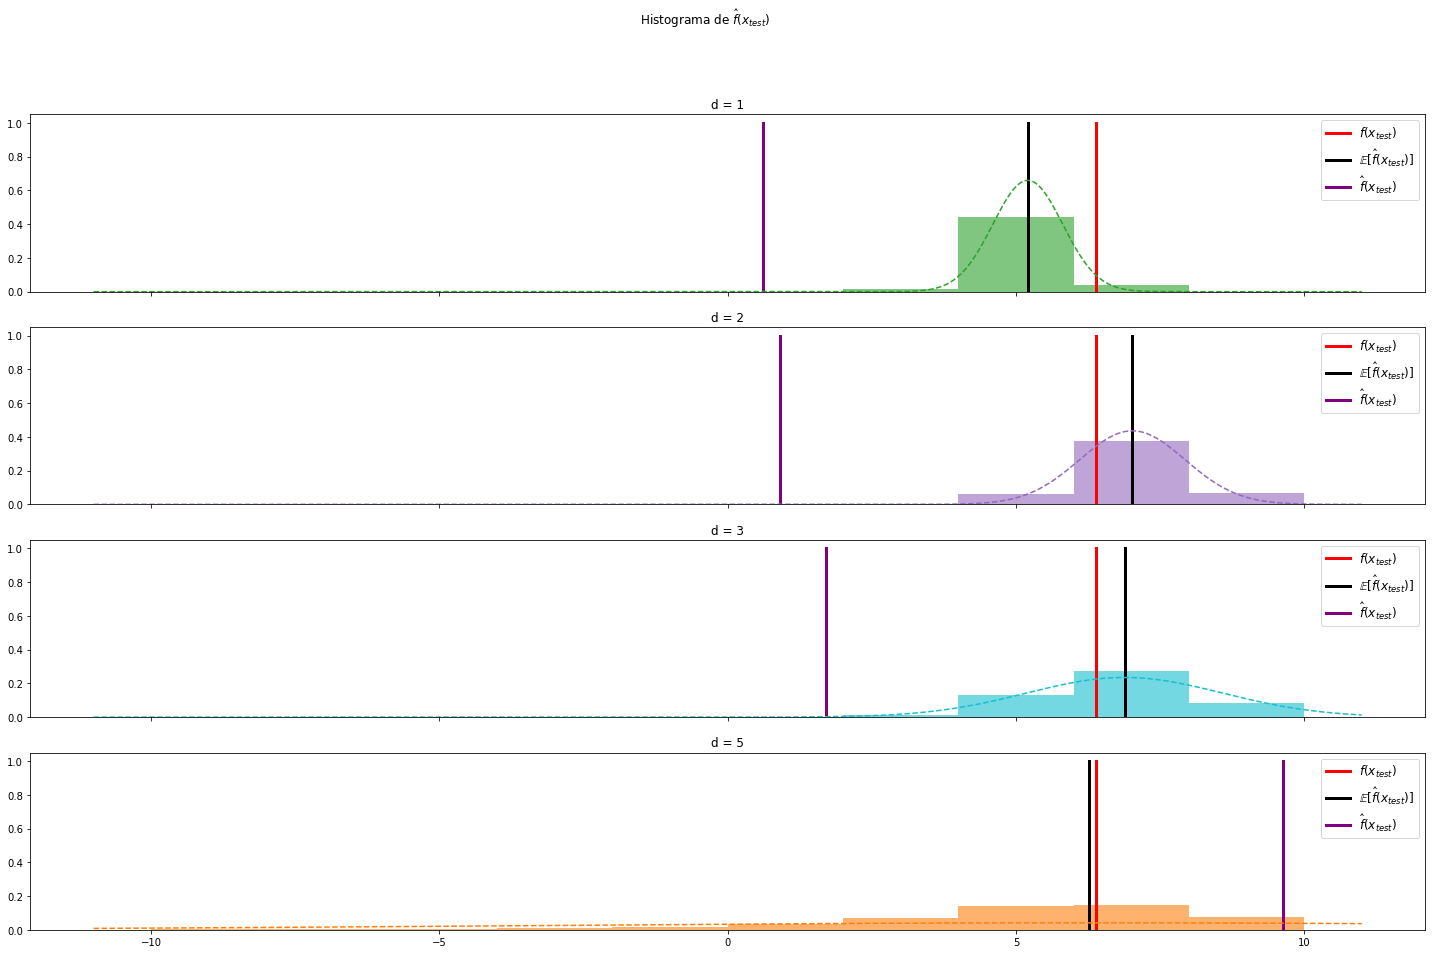

In [44]:
# SIMULACIÓN
# Número de experimentos que vamos a correr para bajar datos al histograma
R = 10000
# Inicialización de la matriz donde guardaremos las predicciones de los
# 10,000 experimentos.
# La matriz es de 4 x 10000, donde el 4 es el número de regresiones de
# las cuales vamos a sacar nuestras predicciones (polinomios de grado
# 1, 2, 3 y 5), y 10000 es el número de experimentos que vamos a realizar.
y_hat_test = np.zeros((len(d_arr), R))
# Vamos a iterar 10,000 veces
for r in range(R):
    # Por cada iteración, definimos de nuevo un num de observaciones que
    # vamos a obtener como muestra para nuestro _train set_.
    n = int(.02 * N)
    # Generamos índices aleatorios para obtener esta muestra aleatoria
    # de observaciones desde nuestro universo.
    idx = np.random.permutation(N)[:n]
    # Subseteamos los arreglos _x_ y _y_ para formar nuestros pares (x,y)
    # de entrenamiento.
    x_train, y_train = x[idx], y[idx]
    # Cada experimento deberá generar 4 regresiones polinomiales con
    # coeficientes diferentes, aunque de los mismos grados los 4:
    for k in range(len(d_arr)):
        # Obtenemos el grado del polinomio del arreglo de órdenes
        d = d_arr[k]
        # Obtenemos la regresión y sus coeficientes
        w = np.polyfit(x_train, y_train, d)
        # Guardamos en nuestro arreglo los pares (x,y), donde _x_ es nuestro
        # punto único y _y_ son las predicciones de los diferentes polinomios
        # para ese punto único.
        y_hat_test[k, r] = f_hat(x_test, w)
# Sacamos la media y la desviación estándar de las predicciones para los 10000
# experimentos de cada polinomio
y_hat_test_mean = np.mean(y_hat_test, 1)
y_hat_test_std = np.std(y_hat_test, 1)

# PLOTS
# Inicializamos un plot de tipo _facet_
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(25, 15))
# Iteramos para los 4 ordenes de polinomios que definimos
for k in range(4):
    # Creamos un histograma donde _x_ es el rango de valores de las predicciones para el orden del
    # polinomio en el arreglo (1, 2, 3, 5), y con límites entre -10 y 10 porque si no, para la
    # regresión polinomial de orden 5, la distribución de predicciones adquiere una cola
    # larguísima.
    axs[k].hist(y_hat_test[k], density=True, color=colors[k], alpha=0.6, range=[-10, 10])             
    # Obtenemos los límites de _x_ para el histograma de este polinomio
    xlim = axs[k].get_xlim()
    # Ploteamos el valor de la función real (que se supone desconocemos) para nuestra nueva observación dada por _x_test_
    axs[k].plot([f(x_test), f(x_test)], [0, 1], 'r', linewidth=3.0)
    # Y luego ploteamos la media de las predicciones dadas por los polinomios en el orden dado por el índice _k_ 
    axs[k].plot([y_hat_test_mean[k], y_hat_test_mean[k]], [0, 1], c='k', linewidth=3.0)
    # Ponemos como título el grado del polinomio en el que estamos iterando
    axs[k].title.set_text('d = {}'.format(d_arr[k]))
    # Y como leyenda, el valor de la función para _x_test_, el promedio de las predicciones para el polinomio en cuestión,
    # la frecuencia de predicciones.
    axs[k].legend([r'$f(x_{test})$', r'$\mathbb{E}[\hat{f}(x_{test})]$', r'$\hat{f}(x_{test})$'], fontsize=12)
# Volvermos a iterar para poder graficar sobre los mismos histogramas, las probability density functions.    
for k in range(4):
    # Definimos el rango de _x_ sacado de _xlim_, que a su vez está dado por los histogramas anteriores
    x_range = np.linspace(xlim[0], xlim[1], 1000)
    # Ploteamos las probability density functions de cada histograma por cada orden de los polinomios
    axs[k].plot(x_range, stats.norm.pdf(x_range, y_hat_test_mean[k], y_hat_test_std[k]), color=colors[k], ls='--')
# Y mostramos el plot
plt.suptitle(r'Histograma de $\hat{f}(x_{test})$', size=12)

Recordemos que:

1. la línea roja es el valor de la función real (que se supone desconocemos), para nuestro único valor de _x\_test_,
2. la línea negra es la media de las predicciones para _x\_test_ obtenidas de la regresión polinomial que corresponde a la gráfica,
3. los valores del histograma son las predicciones mismas obtenidas de la regresión polinomial.

Dado esto, podemos ver que para el polinomio de orden 5, la distancia entre el valor de la función real está **muy cerca** de la media de las predicciones. **Esta distancia es el sesgo**, la diferencia entre el valor real y la media de lo obtenido como predicción. En contraste, en esta regresión de orden 5 vemos que la distribución y el histograma **tienen un _spread_ considerable**. **Este _spread_ es la varianza** de este modelo.

Entre mayor dependencia de _f^(x)_, es decir, el modelo de ML, en pequeñas fluctuaciones dentro del set de entrenamiento, más sensibilidad presentará, y por tanto, mayor varianza.

Vamos ahora a reproducir la gráfica del inicio, donde ploteamos el error total y sus componentes que vimos en la ecuación del inicio.

## Paso 9: ploteo de las curvas de sesgo, varianza, error irreducible, y error total

Vamos a hacerlo con 1000 puntos de prueba en el _test set_, y para regresiones polinomiales de ordenes 0 (línea horizontal), 1 (reg lineal) hasta orden 4.



(0.0, 12.0)

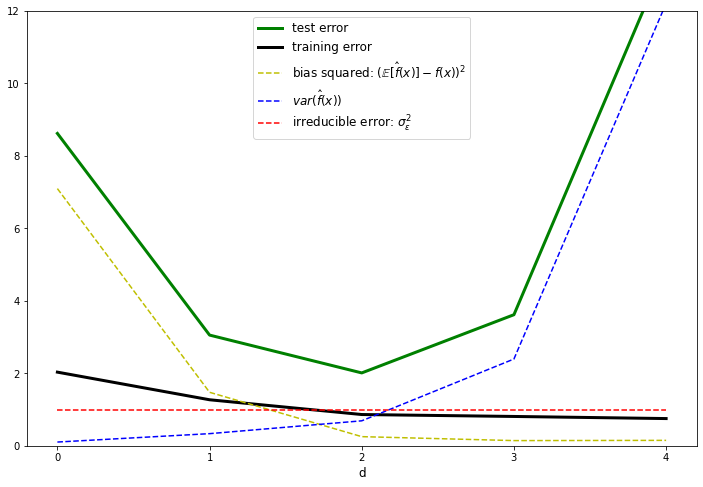

In [50]:
# EXPERIMENTOS
# Volvemos a inicializar valores porque vamos a correr todo desde arriba.
# Num de experimentos
R = 10000
# Num de observaciones del _train set_ para cada reg polinomial
N = 1000
# Muestra de 20 por cada 1000
n = int(.02 * N)
# Reasignamos esta variable de un valor fijo de 3.2, como lo hicimos al inicio,
# a un arreglo de 1000 elementos alrededor de x_max, que es 3
x_test = x_max + np.random.rand(N) - .5  # shape: (N,)
# Obtenemos un arreglo ordenado del 0 al 4
d_arr = np.arange(5)
# Redefinimos epsilon, que es el error irreducible
epsilon = sigma_epsilon * np.random.randn(N)  # shape: (n_test,)
# Redefinimos y_test, que es el resultado de llamar f(x) con valores del _test set_
y_test = f(x_test) + epsilon  # shape: (n_test,)
# Inicializamos una matriz de 5 x 10,000, donde 5 es el número de modelos
# lineales (del 0 al 4) y 10,000 es el num de experimentos que vamos a correr
train_squared_error = np.zeros((len(d_arr), R))  # shape: (len(d_arr), R)
# Inicializamos una matriz de 5 x 10000 x 1000: 5 modelos x 1000 puntos en el _train set_,
# x 10000 experimentos
y_hat_test = np.zeros((len(d_arr), R, N))  # shape: (len(d_arr), R, N)
# Iteramos hasta el 10000 para realizar los 10000 experimentos
for r in range(R):
    # Obtenemos 1000 índices aleatorios con los cuales vamos a obtener 1000 elementos de _x_ y _y_.
    idx = np.random.permutation(N)[:n]
    # Usamos estos índices para obtener 1000 elementos de _x_ y _y_
    x_train, y_train = x[idx], y[idx]  # shape: (n,), (n,)
    # Iteramos de 0 a 4 para generar las regresiones polinomiales
    for k in range(len(d_arr)):
        # Obtenemos el grado del polinomio a ajustar
        d = d_arr[k]
        # Obtenemos los coeficientes de la regresión ajustada con nuestro _train set_
        w = np.polyfit(x_train, y_train, d)
        # Obtenemos el MSE (mean squared error) del _train set_ que es el valor real menos el valor predicho por el modelo elevado al cuadrado
        train_squared_error[k, r] = np.mean((y_train - f_hat(x_train, w)) ** 2)  # train MSE for a specific realization
        # Sacamos las predicciones del _test set_
        y_hat_test[k, r, :] = f_hat(x_test, w)  # test set predictions for a specific realization
# Obtenemos el MSE para el _test set_
test_squared_error = np.mean((y_hat_test - y_test) ** 2, 1)  # shape: (len(d_arr), N)
# Obtenemos el sesgo al cuadrado del _test set_
bias_squared = (np.mean(y_hat_test, 1) - f(x_test)) ** 2  # shape: (len(d_arr), N)
# Obtenemos la varianza de nuestro _test set_
var_y_hat_test = np.var(y_hat_test, 1)  # shape: (len(d_arr), N)

# PLOTS
# Inicializamos un plot normalitp
plt.figure(figsize=(12, 8))
# Ploteamos el MSE del _test set_
plt.plot(d_arr, np.mean(test_squared_error, 1), 'g', linewidth=3.0)  # np.mean(test_squared_error, 1) shape: (len(d_arr),)
# Ploteamos el MSE del _train set_
plt.plot(d_arr, np.mean(train_squared_error, 1), 'k', linewidth=3.0)  # np.mean(train_squared_error, 1) shape: (len(d_arr),)
# Ploteamos el sesgo cuadrado del _test set_
plt.plot(d_arr, np.mean(bias_squared, 1), 'y--')  # np.mean(bias_squared, 1) shape: (len(d_arr),)
# Ploteamos la varianza del _test set_
plt.plot(d_arr, np.mean(var_y_hat_test, 1), 'b--')  # np.mean(var_y_hat_test, 1) shape: (len(d_arr),)
# Y finalmente, ploteamos la sigma de épsilon, que es el error irreducible
plt.plot(d_arr, (sigma_epsilon ** 2) * np.ones_like(d_arr), 'r--')
# Ponemos ticks en X por cada uno de los modelos lineales creados
plt.xticks(d_arr)
# Ponemos labels
plt.xlabel('d', size=12)
# Y legends
plt.legend(['test error', 'training error', r'bias squared: $(\mathbb{E}[\hat{f}(x)] - f(x))^2$',
            r'$var(\hat{f}(x))$', r'irreducible error: $\sigma_\epsilon^2$'], loc='upper center', fontsize=12)
# Y limitamos la Y para encuadrar el plot correctamente
plt.ylim([0, 12])

Podemos observar aquí que el modelo que logra un menor error es la regresión cuadrática, y tiene sentido porque es donde la varianza _var(f^(x))_ y el sesgo _E[f^(x) - f(x)^2^]_ tienen su mínimo, llegando así, al balance entre ambos componentes del error.

## Conclusión

Cuando desarrollamos un modelo, sea clasificación o regresión, debemos de pasar bastante tiempo en la fase de feature selection y/o feature engineering, que es donde no solo nos familiarizamos con el contexto para extraer las mejores variables que estén directamente relacionadas al fenómeno, sino que definimos los _boundaries_ del problema, es decir, **hasta qué punto de la realidad alrededor del problema nos vamos a permitir modelar**. No podemos modelar toda la realidad, y es impráctico introducir todo esto al modelo, lo que nos va a arrastrar al extremo derecho donde caeremos en el overfitting.

Del mismo modo, será irresponsable hacerle al economista de 1990 y tratar de modelar un problema con solo 1 o 2 variables, porque estaremos dejando muchísima información sin considerar dentro de él.

En resumen:

![](https://i.imgur.com/UGZBHdv.png)